# So what is LaserTRAM doing?

Jordan Lubbers

The basic steps of LaserTRAM are:

1. establish two regions of interest:

   1. Background signal
   2. ablation signal we want to calculate the concentration of

2. Subtract the background signal
   1. if an analyte is below detection limit, flag it.
3. normalize the background subtracted signal to an internal standard analyte
4. Record the median and standard error values for the normalized signal for each analyte measured
5. Record the metadata for that analysis: timestamp, interval start and stop times, internal standard counts per second

This notebook will walk through that using the data from the `tests` folder: `spot_test_timestamp_raw_data.xlsx`

Other than the `Dash` specific code (e.g., callbacks and plotly visualizations), this is the _exact_ code from LaserTRAM-DB)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from matplotlib.lines import Line2D
import textwrap
wrapper = textwrap.TextWrapper(width=70)


data_path = r"C:\Users\jlubbers\OneDrive - DOI\Research\Coding\laserTRAM-DB\tests\spot_test_timestamp_raw_data.xlsx"

# keep the colors consistent with the dashboard
colorlist = ["#2E91E5", "#E15F99", "#1CA71C", "#FB0D0D", "#DA16FF", "#222A2A",
             "#B68100", "#750D86", "#EB663B", "#511CFB", "#00A08B", "#FB00D1",
             "#FC0080", "#B2828D", "#6C7C32", "#778AAE", "#862A16", "#A777F1",
             "#620042", "#1616A7", "#DA60CA", "#6C4516", "#0D2A63", "#AF0038",
             "#FD3216", "#00FE35", "#6A76FC", "#FED4C4", "#FE00CE", "#0DF9FF",
             "#F6F926", "#FF9616", "#479B55", "#EEA6FB", "#DC587D", "#D626FF",
             "#6E899C", "#00B5F7", "#B68E00", "#C9FBE5", "#FF0092", "#22FFA7",
             "#E3EE9E", "#86CE00", "#BC7196", "#7E7DCD", "#FC6955", "#E48F72",]

## Import raw data

It should look exactly like this: an excel spreadsheet that contains all the timeseries data for the whole experiment...with the exception of the unique analytes endemic to each experiment.


In [2]:
raw_data = pd.read_excel(data_path)
# convert time from ms to s
raw_data['Time'] = raw_data['Time'] / 1000
raw_data.head()

,timestamp,SampleLabel,Time,7Li,24Mg,27Al,29Si,43Ca,48Ti,57Fe,88Sr,138Ba,139La,140Ce,153Eu,208Pb
0,2021-03-01 22:08:14,BCR-2G_1,0.01324,500.010000,0.0,100.0004,46285.535670,100.0004,0.0000,600.014400,0.0,0.0,0.0,0.0,0.0,100.0004
1,2021-03-01 22:08:14,BCR-2G_1,0.16360,700.019601,0.0,200.0016,43274.778818,0.0000,200.0016,900.032401,0.0,0.0,0.0,0.0,0.0,0.0000
2,2021-03-01 22:08:14,BCR-2G_1,0.31396,600.014400,0.0,400.0064,46586.651171,300.0036,200.0016,1000.040002,0.0,0.0,0.0,0.0,0.0,200.0016
3,2021-03-01 22:08:14,BCR-2G_1,0.46423,800.025601,0.0,100.0004,45683.326387,100.0004,100.0004,1400.078404,0.0,0.0,0.0,0.0,0.0,0.0000
4,2021-03-01 22:08:14,BCR-2G_1,0.61450,600.014400,0.0,300.0036,46185.165445,200.0016,200.0016,700.019601,0.0,0.0,0.0,0.0,0.0,0.0000


In [3]:
# get our analytes, the analytes without their masses (elements),
# and a list of unique spot names
data = raw_data.set_index('SampleLabel')
analytes = data.loc[:, 'Time':].columns.tolist()[1:]
masses = [int(re.findall(f"\d+", analyte)[0]) for analyte in analytes]
spots = data.index.unique().dropna().tolist()


analyte_text = wrapper.wrap(text=f" \x1B[1;4mANALYTES:\x1B[0m {analytes}\n")
for val in analyte_text:
    print(val)
print("\n")
spot_text = wrapper.wrap(text=f"\x1B[1;4mUNIQUE SPOT NAMES:\x1B[0m {spots}")
for val in spot_text:
    print(val)

 ANALYTES: ['7Li', '24Mg', '27Al', '29Si', '43Ca', '48Ti',
'57Fe', '88Sr', '138Ba', '139La', '140Ce', '153Eu', '208Pb']


UNIQUE SPOT NAMES: ['BCR-2G_1', 'BCR-2G_2', 'ATHO-G_1',
'ATHO-G_2', 'BHVO-2G_1', 'BHVO-2G_2', 'unknown_nist-612_1',
'unknown_nist-612_2', 'BCR-2G_3', 'ATHO-G_3', 'BCR-2G_4', 'ATHO-G_4',
'BCR-2G_5', 'ATHO-G_5', 'BCR-2G_6', 'ATHO-G_6', 'BCR-2G_7', 'ATHO-
G_7', 'BCR-2G_8', 'ATHO-G_8', 'BHVO-2G_3', 'unknown_nist-612_3',
'BCR-2G_9', 'ATHO-G_9', 'BCR-2G_10', 'ATHO-G_10', 'BCR-2G_11', 'ATHO-
G_11', 'BCR-2G_12', 'ATHO-G_12', 'BCR-2G_13', 'ATHO-G_13',
'BCR-2G_14', 'BCR-2G_15', 'ATHO-G_14', 'ATHO-G_15', 'BHVO-2G_4',
'BHVO-2G_5', 'unknown_nist-612_4', 'unknown_nist-612_5']


In [4]:
# establish the currrent spot
# this is what the spot dropdown is doing
spot = spots[20]

# isolate as its own dataframe
df = data.loc[spot, 'Time':]

# establish the internal standard
# this is what the int std dropdown does
int_std = "29Si"

# establish the intervals for background and signal
# of interest. This is what the sliders do
bkgd_start = 3
bkgd_stop = 13

int_start = 18
int_stop = 42


# because we are turning everything into numpy arrays
# (easier to do matrix math) we are going to get the
# positions the interval start and  stop times, as well
# as the internal standard.


# Get the position of the interval start and stop times
bkgd_start_idx = np.where(df["Time"] > bkgd_start)[0][0]
bkgd_stop_idx = np.where(df["Time"] > bkgd_stop)[0][0]
int_start_idx = np.where(df["Time"] > int_start)[0][0]
int_stop_idx = np.where((df['Time'] > int_stop))[0][0]


# find the position of the internal standard analyte
# within the list of analytes
for e, i in zip(analytes, range(len(analytes))):
    if e == int_std:
        break
int_std_loc = i

# convert spot data to numpy array
df_n = df.to_numpy()

# get median background counts per second for each analyte
bkgd_data = np.median(df_n[bkgd_start_idx:bkgd_stop_idx, 1:], axis=0)

# get detection limits for each analyte: 3 std devs from bkgd_data
detection_limits = np.std(df_n[bkgd_start_idx:bkgd_stop_idx, 1:], axis=0) * 3

# subtract background from interval signal
bkgd_correct_data = df_n[int_start_idx:int_stop_idx, 1:] - bkgd_data

# normalize background corrected data to internal standard data
bkgd_correct_normal_data = (
    bkgd_correct_data / bkgd_correct_data[:, int_std_loc][:, None])

# median values for normalized data for interval
bkgd_correct_med = np.median(bkgd_correct_normal_data, axis=0)

# flag median values that are below detection limit or 0 with -9999. This flag
# is used later in laser calc to say they are "b.d.l"
bkgd_correct_med[np.median(bkgd_correct_data, axis=0)
                 <= detection_limits] = -9999
bkgd_correct_med[np.median(bkgd_correct_data, axis=0) == 0] = -9999

# standard error of the normalized data over the chosen interval
se = bkgd_correct_normal_data.std(
    axis=0) / np.sqrt(abs(int_stop_idx - int_start_idx))


# relative standard error. This is then used to calculate the uncertainty in ppm
# in laserCalc
rel_se = 100 * (se / bkgd_correct_med)

# turn numpy array back into pandas dataframe and add back in time column.
# This step makes it easier to plot below
bkgd_correct_normal_data = pd.DataFrame(
    bkgd_correct_normal_data, columns=analytes)
bkgd_correct_normal_data["Time"] = df_n[int_start_idx:int_stop_idx, 0] 

## Plot it up

Here is a rough recreation of the LaserTRAM dashboard using the results from above


Text(0, 0.5, '% SE')

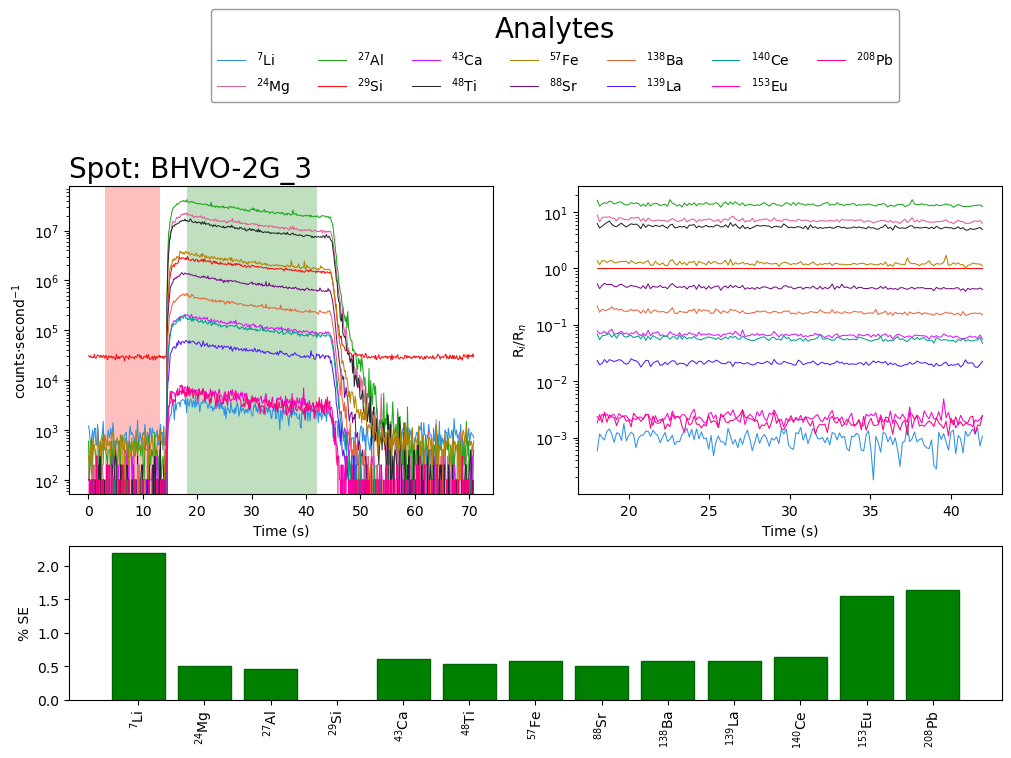

In [5]:
fig, ax = plt.subplot_mosaic(
    [
        ["raw", "normal"],
        ["bar", "bar"]
    ],
    figsize=(10, 6),
    height_ratios=[4, 2],
    layout="constrained",
)
ax["raw"].set_title(f"Spot: {spot}", loc="left", fontsize=20)
for analyte, color in zip(analytes, colorlist):
    ax["raw"].plot(df["Time"], df[analyte], color=color, lw=0.75)
    ax["normal"].plot(
        bkgd_correct_normal_data["Time"],
        bkgd_correct_normal_data[analyte],
        color=color,
        lw=0.75,
    )
ax["raw"].set_yscale("log")
ax["normal"].set_yscale("log")

ax["raw"].axvspan(
    df["Time"][bkgd_start_idx],
    df["Time"][bkgd_stop_idx],
    facecolor="r",
    alpha=0.25
)
ax["raw"].axvspan(
    df["Time"][int_start_idx],
    df["Time"][int_stop_idx],
    facecolor="g",
    alpha=0.25
)

labels = [
    "$^{{{}}}${}".format(
        re.findall(r"\d+", analyte)[0],
        analyte.replace(re.findall(r"\d+", analyte)[0], ""),
    )
    for analyte in analytes
]
legend_elements = [
    Line2D([0], [0], color=c, lw=0.75, label=l) for c, l in zip(colorlist, labels)
]
legend = fig.legend(
    handles=legend_elements,
    title="Analytes",
    title_fontsize=20,
    fontsize=10,
    bbox_to_anchor=[0.9, 1.25],
    ncol=7,
    fancybox=True,
    edgecolor="gray",
)
ax["raw"].set_ylabel("counts$\cdot$second$^{-1}$")
ax["normal"].set_ylabel("R$_i$/R$_n$")
ax["raw"].set_xlabel("Time (s)")
ax["normal"].set_xlabel("Time (s)")

bar_colors = [
    {s <= 0: "none", 0 < s <= 5: "green", s > 5: "orange"}[True] for s in rel_se
]
edge_colors = [
    {s <= 0: "none", 0 < s <= 5: "darkgreen", s > 5: "C1"}[True] for s in rel_se
]
ax["bar"].bar(x=labels,
              height=rel_se,
              color=bar_colors,
              ec=edge_colors
              )
ax["bar"].set_xticks(
    ax["bar"].get_xticks(), labels=ax["bar"].get_xticklabels(), rotation=90
)
ax["bar"].set_ylim(0)
ax["bar"].minorticks_off()
ax["bar"].set_ylabel("% SE")

## A function for repetitive use


In [6]:
def do_lasertram(raw_data, spot, bkgd_interval, keep_interval, int_std):
    """A function for doing all the operations in the LaserTRAM-DB
    LaserTRAM tab of the dashboard...minus the dash stuff

    Args:
        raw_data (pandas DataFrame): DataFrame of raw data used as the
        input to LaserTRAM
        spot (str): the unique "SampleLabel" identifier for the spot
        to be processed.
        bkgd_interval (tuple): (start , stop) in seconds of the background 
        interval
        keep_interval (tuple): (start , stop) in seconds of the interval
        of interest for concentrations
        int_std (str): the analyte to be used as the internal standard
        (e.g., what all other analytes are normalized to; 29Si)

    Returns:
        spot_data (pandas DataFrame): a 1 row DataFrame that has the following 
        format:
        |timestamp|spot|bkgd_start|bkgd_stop|int_start|int_stop|norm|norm_cps|analytes...|errors...|
        --------------------------------------------------------------------------------------------
        timestamp: unique datetime identifier of the analysis
        spot: unique name identifier of the analysis
        bkgd_start: analysis time (s) where the interval denoted as background signal starts
        bkgd_stop: analysis time (s) where the interval denoted as background signal stops
        int_start: analysis time (s) where the interval for material of interest signal starts
        int_stop: analysis time (s) where the interval for material of interest signal stops
        norm: internal standard analyte
        norm_cps: median counts per second of internal standard over the (int_start,int_stop) range
        analytes...: columns for each analyte's median normalized value 
        errors...: columns for each analyte's relative standard error 

    """
  

    data = raw_data.set_index("SampleLabel")

    # filter for spot chosen and exclude timestamp column
    if "timestamp" in data.columns.tolist():
        timestamp = str(data.loc[spot, "timestamp"].unique()[0])
        df = data.loc[spot, :]
        df = df.loc[:, "Time":]

    else:
        # isolate as its own dataframe
        df = data.loc[spot, "Time":]
    # because we are turning everything into numpy arrays
    # (easier to do matrix math) we are going to get the
    # positions the interval start and  stop times, as well
    # as the internal standard.
    
    # establish the intervals for background and signal
    # of interest. This is what the sliders do
    bkgd_start = bkgd_interval[0]
    bkgd_stop = bkgd_interval[1]

    int_start = keep_interval[0]
    int_stop = keep_interval[1]

    # Get the position of the interval start and stop times
    bkgd_start_idx = np.where(df["Time"] > bkgd_start)[0][0]
    bkgd_stop_idx = np.where(df["Time"] > bkgd_stop)[0][0]
    int_start_idx = np.where(df["Time"] > int_start)[0][0]
    int_stop_idx = np.where((df["Time"] > int_stop))[0][0]

    # find the position of the internal standard analyte
    # within the list of analytes
    for e, i in zip(analytes, range(len(analytes))):
        if e == int_std:
            break
    int_std_loc = i

    # convert spot data to numpy array
    df_n = df.to_numpy()

    # get median background counts per second for each analyte
    bkgd_data = np.median(df_n[bkgd_start_idx:bkgd_stop_idx, 1:], axis=0)

    # get detection limits for each analyte: 3 std devs from bkgd_data
    detection_limits = np.std(
        df_n[bkgd_start_idx:bkgd_stop_idx, 1:], axis=0) * 3

    # subtract background from interval signal
    bkgd_correct_data = df_n[int_start_idx:int_stop_idx, 1:] - bkgd_data

    # normalize background corrected data to internal standard data
    bkgd_correct_normal_data = (
        bkgd_correct_data / bkgd_correct_data[:, int_std_loc][:, None]
    )

    # median values for normalized data for interval
    bkgd_correct_med = np.median(bkgd_correct_normal_data, axis=0)

    # flag median values that are below detection limit or 0 with -9999. This flag
    # is used later in laser calc to say they are "b.d.l"
    bkgd_correct_med[np.median(bkgd_correct_data, axis=0)
                     <= detection_limits] = -9999
    bkgd_correct_med[np.median(bkgd_correct_data, axis=0) == 0] = -9999

    # standard error of the normalized data over the chosen interval
    se = bkgd_correct_normal_data.std(axis=0) / np.sqrt(
        abs(int_stop_idx - int_start_idx)
    )

    # relative standard error. This is then used to calculate the uncertainty in ppm
    # in laserCalc
    rel_se = 100 * (se / bkgd_correct_med)

    # turn numpy array back into pandas dataframe and add back in time column.
    # This step makes it easier to plot below
    bkgd_correct_normal_data = pd.DataFrame(
        bkgd_correct_normal_data, columns=analytes)
    bkgd_correct_normal_data["Time"] = df_n[int_start_idx:int_stop_idx, 0]

    spot_data = pd.DataFrame(
        [
            timestamp,
            spot,
            df["Time"][bkgd_start_idx],
            df["Time"][bkgd_stop_idx],
            df["Time"][int_start_idx],
            df["Time"][int_stop_idx],
            int_std,
            np.median(bkgd_correct_data[:, int_std_loc]),
        ]
    ).T
    spot_data.columns = [
        "timestamp",
        "Spot",
        "bkgd_start",
        "bkgd_stop",
        "int_start",
        "int_stop",
        "norm",
        "norm_cps",
    ]
    spot_data = pd.concat(
        [
            spot_data,
            pd.DataFrame(bkgd_correct_med[np.newaxis, :], columns=analytes),
            pd.DataFrame(
                rel_se[np.newaxis, :], columns=[
                    f"{analyte}_se" for analyte in analytes]
            ),
        ],
        axis="columns",
    )

    return spot_data

In [7]:
do_lasertram(raw_data, spots[10], (3, 13), (18, 43), '29Si')

,timestamp,Spot,bkgd_start,bkgd_stop,int_start,int_stop,norm,norm_cps,7Li,24Mg,...,29Si_se,43Ca_se,48Ti_se,57Fe_se,88Sr_se,138Ba_se,139La_se,140Ce_se,153Eu_se,208Pb_se
0,2021-03-01T22:59:34.000000000,BCR-2G_4,3.01955,13.09152,18.05249,43.0058,29Si,2680190.778812,0.001954,3.293167,...,0.0,0.644957,0.5559,0.475252,0.509302,0.461455,0.603052,0.577382,1.173726,0.7035


## Recreating LaserTRAM output

We can re-create the output from the dashboard by just strapping the output from `do_lasertram` to itself as we iterate through spots. This however necissitates that you already know the ablation interval of interest! That is, after all the whole point of the dashboard! To have complete control on the interval of interest used in calculating concentrations. Because I know that all of the spots in this test data are the same (and standard reference materials with no inclusions or heterogeneities) I can keep this the same to show how we can loop through the process calling the function:


In [8]:
bkgd_interval = (3, 13)
ablation_interval = (18, 43)

lasertram_results = pd.DataFrame()
for spot in spots:
    lasertram_results = pd.concat(
        [
            lasertram_results,
            do_lasertram(raw_data, spot, bkgd_interval,
                         ablation_interval, "29Si"),
        ]
    )

lasertram_results.head()

,timestamp,Spot,bkgd_start,bkgd_stop,int_start,int_stop,norm,norm_cps,7Li,24Mg,...,29Si_se,43Ca_se,48Ti_se,57Fe_se,88Sr_se,138Ba_se,139La_se,140Ce_se,153Eu_se,208Pb_se
0,2021-03-01T22:08:14.000000000,BCR-2G_1,3.01948,13.09122,18.05195,43.00714,29Si,2815412.431343,0.001880,3.234536,...,0.0,1.040229,0.755615,0.671882,0.673229,0.656124,0.858927,0.798088,1.404934,1.618659
0,2021-03-01T22:09:31.000000000,BCR-2G_2,3.01974,13.09189,18.05249,43.00679,29Si,2863482.836319,0.001868,3.275038,...,0.0,0.649150,0.522757,0.446520,0.524548,0.508187,0.530943,0.561342,1.156161,0.687185
0,2021-03-01T22:10:48.000000000,ATHO-G_1,3.0198,13.09122,18.05188,43.00666,29Si,2806244.236598,0.003843,0.062872,...,0.0,2.615348,0.465423,0.465237,0.476553,0.435259,0.392594,0.482907,1.171290,5.246184
0,2021-03-01T22:12:05.000000000,ATHO-G_2,3.01965,13.09162,18.05241,43.00712,29Si,2870866.126938,0.003900,0.062645,...,0.0,0.686159,0.435185,0.454395,0.378679,0.331505,0.353850,0.358209,1.037214,1.693333
0,2021-03-01T22:13:22.000000000,BHVO-2G_1,3.01995,13.09222,18.05255,43.00582,29Si,2073876.678872,0.000958,6.808068,...,0.0,1.110853,1.240103,1.302181,1.135065,1.371473,1.219394,1.657898,1.644600,9.168401


## Plotting raw data
The above loop would be more useful if we had "eyes" on our raw data so we could update the desired interval each iteration should we need to. Here's some code to do that individually and then in a loop and save you some time:

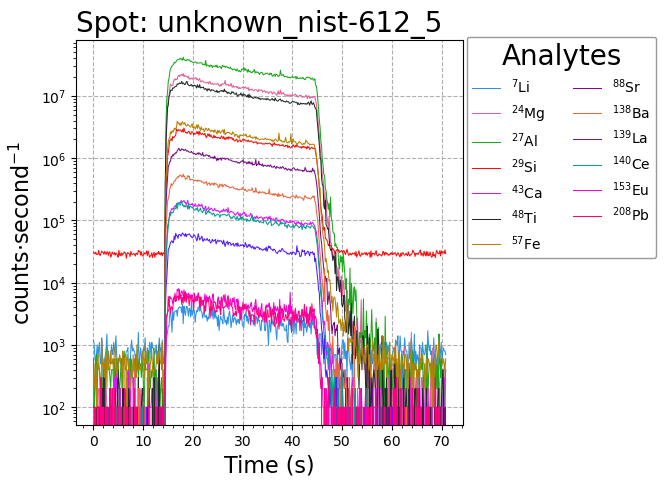

In [9]:
fig, ax = plt.subplots(figsize = (5,5))
ax.set_title(f"Spot: {spot}", loc="left", fontsize=20)
for analyte, color in zip(analytes, colorlist):
    ax.plot(df["Time"], df[analyte], color=color, lw=0.75)

ax.set_yscale("log")

labels = [
    "$^{{{}}}${}".format(
        re.findall(r"\d+", analyte)[0],
        analyte.replace(re.findall(r"\d+", analyte)[0], ""),
    )
    for analyte in analytes
]
legend_elements = [
    Line2D([0], [0], color=c, lw=0.75, label=l) for c, l in zip(colorlist, labels)
]
legend = fig.legend(
    handles=legend_elements,
    title="Analytes",
    title_fontsize=20,
    fontsize=10,
    bbox_to_anchor=[1.3, .9],
    ncol=2,
    fancybox=True,
    edgecolor="gray",
)
ax.set_ylabel("counts$\cdot$second$^{-1}$",fontsize = 16)
ax.set_xlabel("Time (s)",fontsize = 16)
ax.minorticks_on()
ax.grid(ls = '--',)


In [10]:
export_path = r"C:\Users\jlubbers\OneDrive - DOI\Desktop\test_figures"
for spot in spots:
    df = data.loc[spot,:]
    fig, ax = plt.subplots(figsize = (5,5))
    ax.set_title(f"Spot: {spot}", loc="left", fontsize=20)
    for analyte, color in zip(analytes, colorlist):
        ax.plot(df["Time"], df[analyte], color=color, lw=0.75)

    ax.set_yscale("log")

    labels = [
        "$^{{{}}}${}".format(
            re.findall(r"\d+", analyte)[0],
            analyte.replace(re.findall(r"\d+", analyte)[0], ""),
        )
        for analyte in analytes
    ]
    legend_elements = [
        Line2D([0], [0], color=c, lw=0.75, label=l) for c, l in zip(colorlist, labels)
    ]
    legend = fig.legend(
        handles=legend_elements,
        title="Analytes",
        title_fontsize=20,
        fontsize=10,
        bbox_to_anchor=[1.3, .9],
        ncol=2,
        fancybox=True,
        edgecolor="gray",
    )
    ax.set_ylabel("counts$\cdot$second$^{-1}$",fontsize = 16)
    ax.set_xlabel("Time (s)",fontsize = 16)
    ax.minorticks_on()
    ax.grid(ls = '--',)

    plt.savefig(f"{export_path}\{spot}_raw_data.pdf",bbox_inches = 'tight')
    plt.close()
